In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,learning_curve, cross_val_score
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn import tree
import scipy.stats as stats
import optuna
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import shap
from scipy.special import expit

In [2]:
df = pd.read_csv(r"C:\Users\Robyi\Documents\Data Science Dataset\vodka.csv")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
x = df.drop(columns=['quality'])
y = df['quality']

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)

In [5]:
def objective(trial):
    criterion = trial.suggest_categorical('criterion',{'squared_error', 'absolute_error', 'poisson', 'friedman_mse'})
    splitter = trial.suggest_categorical('splitter',{'best', 'random'})
    max_depth= trial.suggest_int('max_depth',2, 20)
    min_samples_split = trial.suggest_int('min_samples_split',2,20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf',2, 20)
    max_features= trial.suggest_categorical('max_features',{None,"sqrt","log2"})

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('dt',DecisionTreeRegressor(criterion=criterion, splitter=splitter, max_depth=max_depth, min_samples_split=min_samples_split,
                                   min_samples_leaf=min_samples_leaf, max_features=max_features, random_state=42))
    ])

    pipeline.fit(x_train, y_train)
    y_pred = pipeline.predict(x_test)
    return mean_squared_error(y_test, y_pred) 

In [6]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials =20)

best_params = study.best_params

best_model = Pipeline([
    ('scaler',StandardScaler()),
    ('dt',DecisionTreeRegressor(criterion=best_params['criterion'], splitter=best_params['splitter'], max_depth=best_params['max_depth'],
                                 min_samples_split=best_params['min_samples_split'],
                                   min_samples_leaf=best_params['min_samples_leaf'], max_features=best_params['max_features'], random_state=42))
])

[I 2025-02-14 19:36:39,553] A new study created in memory with name: no-name-2e98e786-c850-48cc-92cc-b2829ba8b1eb
[I 2025-02-14 19:36:39,605] Trial 0 finished with value: 0.450876753496285 and parameters: {'criterion': 'friedman_mse', 'splitter': 'best', 'max_depth': 17, 'min_samples_split': 17, 'min_samples_leaf': 18, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.450876753496285.
[I 2025-02-14 19:36:39,697] Trial 1 finished with value: 0.5375 and parameters: {'criterion': 'absolute_error', 'splitter': 'random', 'max_depth': 17, 'min_samples_split': 9, 'min_samples_leaf': 18, 'max_features': None}. Best is trial 1 with value: 0.5375.
[I 2025-02-14 19:36:39,745] Trial 2 finished with value: 0.45076586703459326 and parameters: {'criterion': 'friedman_mse', 'splitter': 'best', 'max_depth': 17, 'min_samples_split': 19, 'min_samples_leaf': 16, 'max_features': 'sqrt'}. Best is trial 1 with value: 0.5375.
[I 2025-02-14 19:36:39,845] Trial 3 finished with value: 0.47774407729884005 an

In [7]:
best_model.fit(x_train, y_train)

y_pred = best_model.predict(x_test)
print(y_pred)

[5.  5.  5.  5.  5.  6.  5.  5.  6.  6.  6.  5.  5.  5.  5.5 7.  5.  5.
 6.  5.  5.  5.  5.  5.  5.  5.  7.  5.  5.  6.  5.  6.  6.  5.  5.  5.
 6.  6.  5.  6.  6.  5.  6.  5.  6.  5.  6.  6.  5.  5.  5.  5.  5.  6.
 5.  5.  5.  5.  6.  5.  6.  6.  6.  5.  6.  6.  6.  5.  6.  5.  6.  5.
 6.  5.  5.  5.  6.  6.  5.  6.5 5.  6.  5.  5.  5.  5.  5.  6.  6.  6.
 5.  7.  5.  5.  6.  6.  5.  5.  5.  5.  5.  5.  5.  5.  5.  6.  6.  5.
 7.  5.  6.  5.  5.  5.  5.  6.  5.  5.  5.  5.  7.  5.  5.  5.  5.  5.
 6.  5.  6.  6.  6.  5.  5.  6.  5.  5.  5.  5.  5.  5.  6.  6.  6.  5.
 6.  5.  6.  5.  6.  5.  5.  5.  5.  5.  6.  6.5 5.  6.  5.  5.  6.  6.
 6.  5.  5.  5.  5.  5.  6.  5.  5.  5.  6.  5.  6.  5.  6.  5.5 6.  5.
 5.  6.  5.  7.  5.  6.  5.  5.  7.  5.  5.  6.  5.  6.  6.  6.  5.  6.
 5.  6.  5.  5.  6.  5.  7.  5.  5.  6.  6.  5.  6.  5.  6.  5.  6.  5.
 5.  5.  5.  5.  5.  6.5 6.  6.  5.  5.  5.  6.  6.  6.  5.  5.  7.  5.
 5.  6.  5.  5.  5.  5.  5.  5.  5.  6.  6.  6.  5.  5.  6.  5. 

In [12]:
proba = expit(y_pred)
print(proba)

[0.99330715 0.99330715 0.99330715 0.99330715 0.99330715 0.99752738
 0.99330715 0.99330715 0.99752738 0.99752738 0.99752738 0.99330715
 0.99330715 0.99330715 0.99592986 0.99908895 0.99330715 0.99330715
 0.99752738 0.99330715 0.99330715 0.99330715 0.99330715 0.99330715
 0.99330715 0.99330715 0.99908895 0.99330715 0.99330715 0.99752738
 0.99330715 0.99752738 0.99752738 0.99330715 0.99330715 0.99330715
 0.99752738 0.99752738 0.99330715 0.99752738 0.99752738 0.99330715
 0.99752738 0.99330715 0.99752738 0.99330715 0.99752738 0.99752738
 0.99330715 0.99330715 0.99330715 0.99330715 0.99330715 0.99752738
 0.99330715 0.99330715 0.99330715 0.99330715 0.99752738 0.99330715
 0.99752738 0.99752738 0.99752738 0.99330715 0.99752738 0.99752738
 0.99752738 0.99330715 0.99752738 0.99330715 0.99752738 0.99330715
 0.99752738 0.99330715 0.99330715 0.99330715 0.99752738 0.99752738
 0.99330715 0.99849882 0.99330715 0.99752738 0.99330715 0.99330715
 0.99330715 0.99330715 0.99330715 0.99752738 0.99752738 0.9975

In [13]:
prediksi = pd.read_csv(r"C:\Users\Robyi\Documents\Data Science Dataset\vodkapredict.csv")
prediksi.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,8.6,0.38,0.36,3.0,0.081,30.0,119.0,0.9970,3.20,0.56,9.4
1,7.6,0.51,0.15,2.8,0.110,33.0,73.0,0.9955,3.17,0.63,10.2
2,7.7,0.62,0.04,3.8,0.084,25.0,45.0,0.9978,3.34,0.53,9.5
3,10.2,0.42,0.57,3.4,0.070,4.0,10.0,0.9971,3.04,0.63,9.6
4,7.5,0.63,0.12,5.1,0.111,50.0,110.0,0.9983,3.26,0.77,9.4


In [14]:
y_prediksi = best_model.predict(prediksi)
probabilitas_prediksi = expit(y_prediksi)
print(y_prediksi)
print(probabilitas_prediksi)

[5. 5. 5. 5. 5. 5.]
[0.99330715 0.99330715 0.99330715 0.99330715 0.99330715 0.99330715]


In [15]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test,y_pred)
r2 = r2_score(y_test, y_pred)

n = len(y_test)
p = x_test.shape[1]
r2_adj = 1 - ((1-r2) * (n - 1) / (n - p - 1))

print(mse)
print(mae)
print(rmse)
print(r2)
print(r2_adj)

0.7
0.590625
0.8366600265340756
-0.07114571347449883
-0.10940091752715952


In [27]:
cv_scores = cross_val_score(best_model, x_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", np.mean(cv_scores))

Cross-Validation Scores: [-0.80114101 -0.80711976 -0.77521709 -0.77444149 -0.76613088]
Mean CV Accuracy: -0.784810045725697


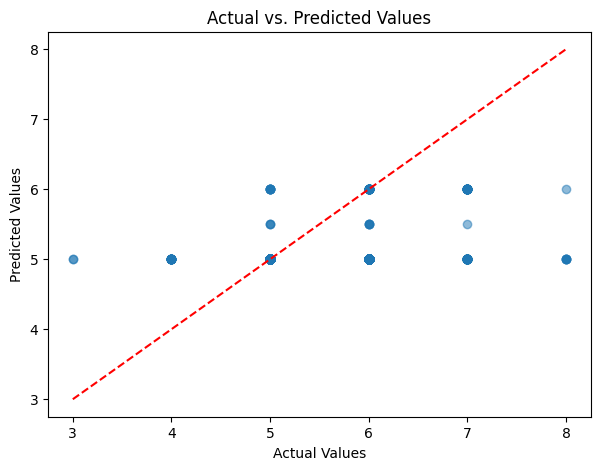

In [9]:
plt.figure(figsize=(7, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--') 
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.show()

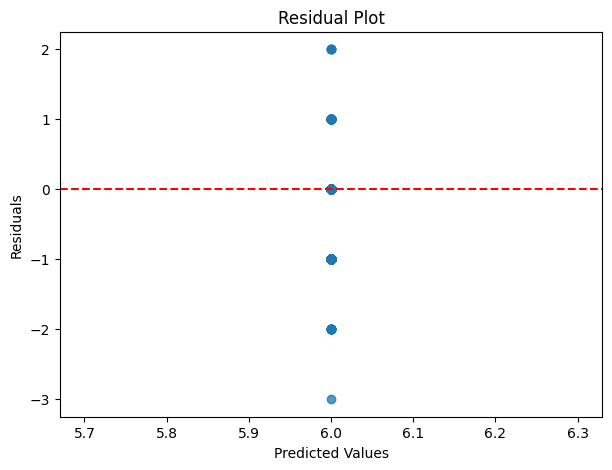

In [20]:
residuals = y_test - y_pred

plt.figure(figsize=(7, 5))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

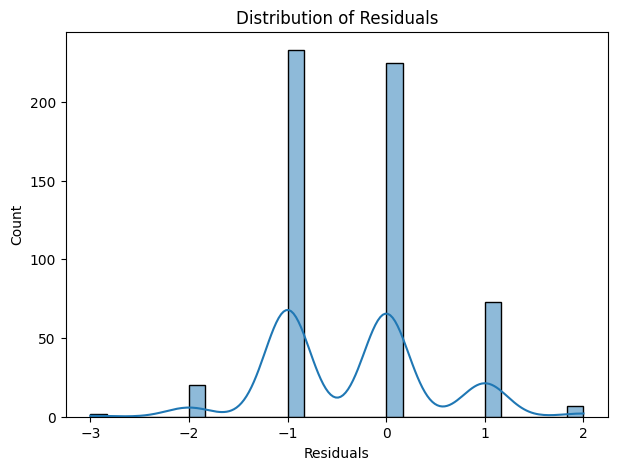

In [21]:
plt.figure(figsize=(7, 5))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel("Residuals")
plt.title("Distribution of Residuals")
plt.show()

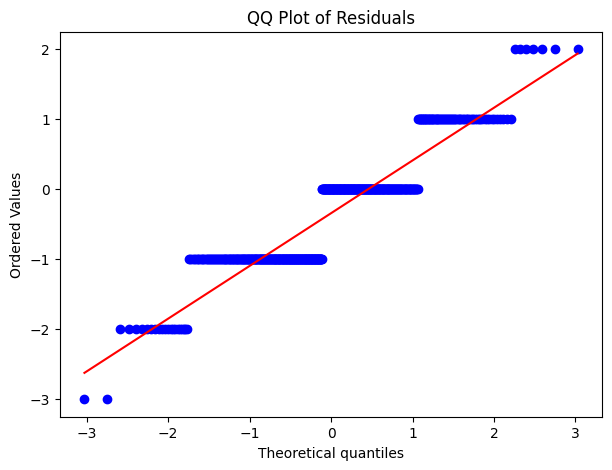

In [22]:
plt.figure(figsize=(7, 5))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot of Residuals")
plt.show()

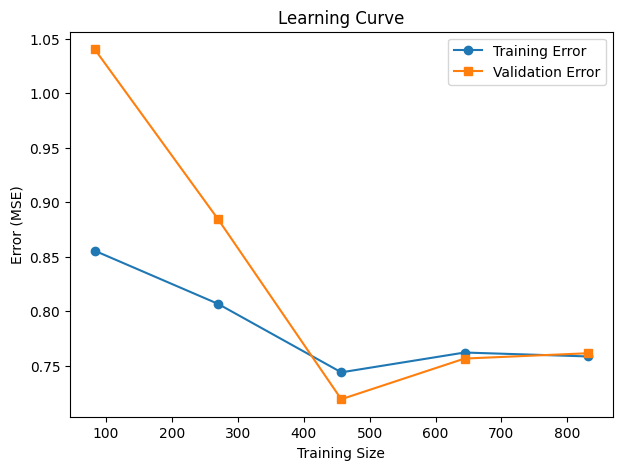

In [23]:
train_sizes, train_scores, test_scores = learning_curve(best_model, x_train, y_train, cv=5, scoring="neg_mean_squared_error")

train_mean = -train_scores.mean(axis=1)
test_mean = -test_scores.mean(axis=1)

plt.figure(figsize=(7, 5))
plt.plot(train_sizes, train_mean, label="Training Error", marker="o")
plt.plot(train_sizes, test_mean, label="Validation Error", marker="s")
plt.xlabel("Training Size")
plt.ylabel("Error (MSE)")
plt.legend()
plt.title("Learning Curve")
plt.show()

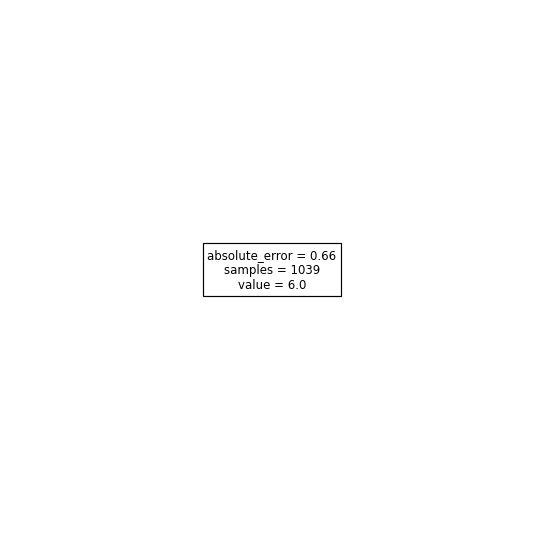

In [29]:
plt.rcParams['figure.dpi'] = 85
plt.subplots(figsize=(8,8))
tree.plot_tree(best_model, fontsize=10)
plt.show()

In [28]:
dt = best_model.named_steps['dt']
feature_importances = pd.DataFrame({
    'Feature': x.columns,
    'Importance': dt.feature_importances_
}).sort_values(by='Importance', ascending =False)

print(feature_importances)

                 Feature  Importance
10               alcohol     0.28750
7                density     0.28125
2            citric acid     0.22500
1       volatile acidity     0.05000
4              chlorides     0.04375
3         residual sugar     0.03125
5    free sulfur dioxide     0.03125
6   total sulfur dioxide     0.01875
9              sulphates     0.01875
8                     pH     0.01250
0          fixed acidity     0.00000


C:\Users\Robyi\AppData\Local\Temp\ipykernel_15428\3486866868.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances['Importance'], y=feature_importances['Feature'], orient="h", palette="viridis")


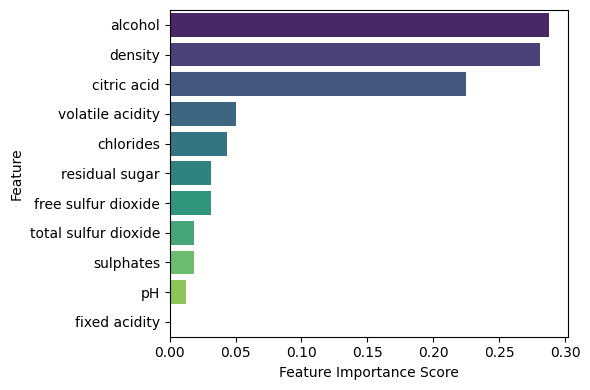

In [29]:
plt.figure(figsize=(6, 4))
sns.barplot(x=feature_importances['Importance'], y=feature_importances['Feature'], orient="h", palette="viridis")
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.tight_layout()

In [30]:
explainer = shap.Explainer(dt, x_train)
shap_values = explainer(x_test)

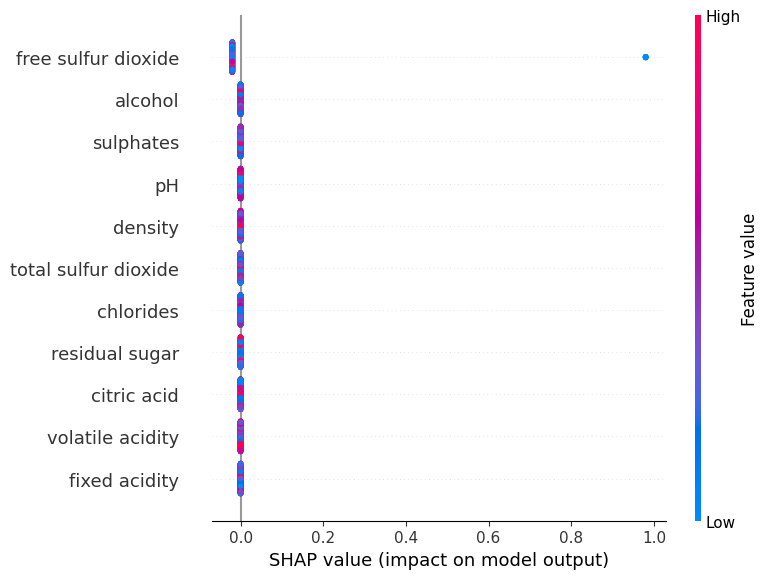

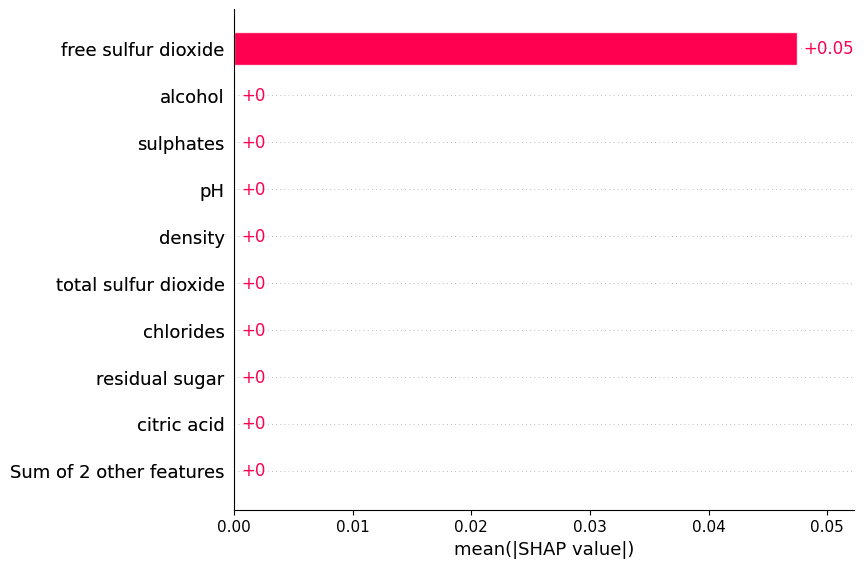

In [31]:
shap.summary_plot(shap_values, x_test, feature_names=x.columns)
shap.plots.bar(shap_values)